# Segmentation and Clustering of Toronto Neighbourhood

Importing required libraries

In [2]:
import pandas as pd
from bs4 import BeautifulSoup 
import requests

In [17]:
toronto = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
bs=BeautifulSoup(toronto,'html')

In [35]:
table_contents=[]
table=bs.find('table')
for row in table.findAll('td'):
    cell = {}
    #print(row.span.text)
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
#df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A','East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto', 'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [36]:
df['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'East YorkEast Toronto', 'Central Toronto',
       'MississaugaCanada Post Gateway Processing Centre',
       'Downtown TorontoStn A PO Boxes25 The Esplanade',
       'EtobicokeNorthwest',
       'East TorontoBusiness reply mail Processing Centre969 Eastern'],
      dtype=object)

In [30]:
df[df.PostalCode=='M5A']

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [31]:
df[df.Neighborhood=='Not assigned']

,PostalCode,Borough,Neighborhood


In [32]:
df.shape

(103, 3)

The dataset is prepared by removing any neighbourhoods that do not have values ( 'not assgined') and appending the Neighbourhood names when there are multiple found for a postal code.

### Adding Geocodes

In [41]:
geocodes=pd.read_csv(r'D:\OneDrive - Infosys Limited\UG\coursera\Geospatial_Coordinates.csv')

In [43]:
df_geo=pd.merge(df,geocodes, right_on='Postal Code', left_on='PostalCode', how='left')

In [44]:
df_geo

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,M7A,43.662301,-79.389494
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",M8X,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,M7Y,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",M8Y,43.636258,-79.498509


## Clustering of Toronto Neighbourhoods

In [54]:
## Extracting only boroughs that contain the word toronto
df_geo_tor=df_geo.loc[(df_geo['Borough'].str.contains('toronto|Toronto'))]

In [69]:
import folium
tmap = folium.Map(location=[43.651070,-79.347015],zoom_start=12)

for lat,lng,Borough,Neighborhood in zip(df_geo_tor['Latitude'],df_geo_tor['Longitude'],df_geo_tor['Borough'],df_geo_tor['Neighborhood']):
    label = '{}, {}'.format(Neighborhood, Borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(tmap)
tmap

Output of Map added embeeded as image as ouput may not showup in GitHub 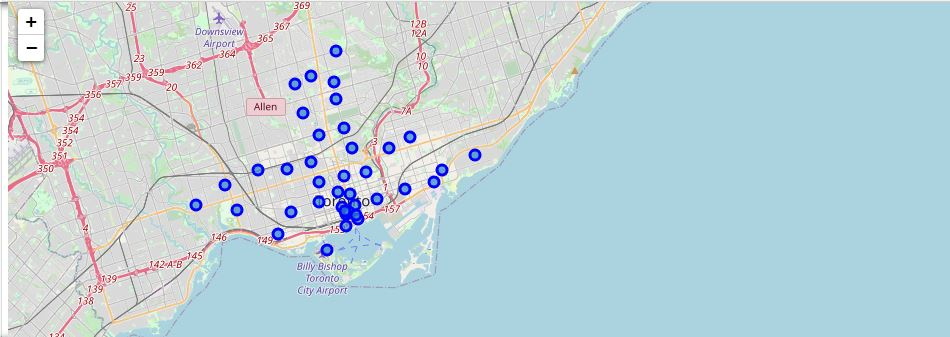

In [83]:
### Clustering the neighbourhoods
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

toronto_clusters = df_geo_tor.drop(['PostalCode','Postal Code','Borough','Neighborhood'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
df_geo_tor['Cluster Labels']=kmeans.labels_

D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
kmeans.labels_

array([0, 0, 0, 3, 0, 0, 2, 0, 4, 3, 0, 2, 3, 0, 2, 3, 0, 3, 1, 1, 1, 1,
       4, 1, 2, 4, 1, 2, 4, 1, 2, 1, 0, 0, 0, 0, 0, 0, 3])

In [86]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_geo_tor['Latitude'], df_geo_tor['Longitude'], df_geo_tor['Neighborhood'], df_geo_tor['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Output of Map added embeeded as image as ouput may not showup in GitHub 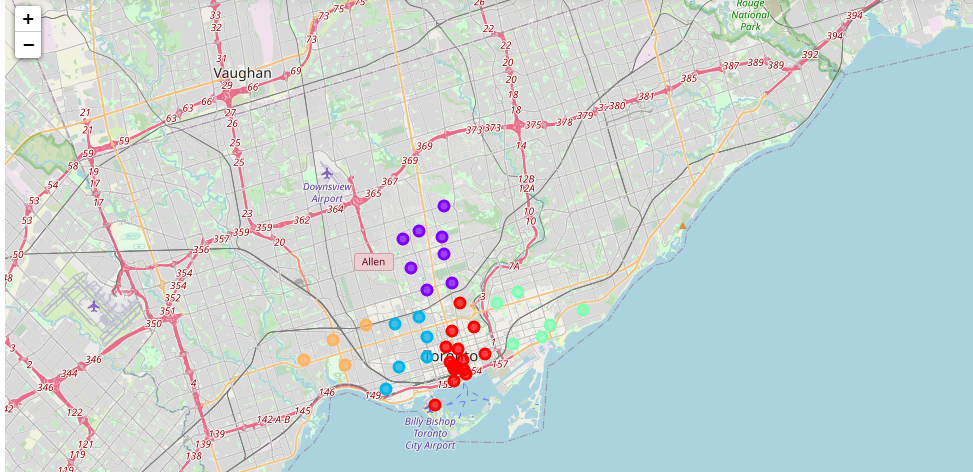 

Clustering is applied on only the neightbourhoods that contains 'Toronto' in the Borough name. The clustering is done based on the Lat and Long values.

KMeans clustering groups the data into 5 clusters. Clustering shows proximity of the nrighbourhoods based on the location.